In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastcore.xtras import load_pickle

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_photoswitch_smiles_pred, evaluate_generated_smiles

from gptchem.settings import ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH

from guacamol.utils.chemistry import is_valid
from glob import glob
import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

import matplotx


%matplotlib inline

In [3]:
from rdkit import Chem

In [4]:
all_res = glob('out/**/*.pkl')

In [5]:
res = load_pickle(all_res[0])

In [6]:
from collections import defaultdict

In [7]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [8]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res['res_at_temp']:


        metrics= {
            'noise_level': res['noise_level'],
            'temp': temp_res['temperature'],
            'frac_valid': temp_res['frac_valid'],
            'frac_unique': temp_res['frac_unique'],
            'frac_smiles_in_train': temp_res['frac_smiles_in_train'],
            'frac_smiles_in_pubchem': temp_res['frac_smiles_in_pubchem'],
            'kld': temp_res['kld'],
            'frechet_d': temp_res['frechet_d'],
            'frechet_score': temp_res['frechet_score'],
            'frac_contains_azo': sum([contains_azo(s) for s in temp_res['valid_smiles']]) / len(temp_res['valid_smiles']),
        }

        generated_smiles.update([s for s in temp_res['generated_smiles'] if is_valid(s)])
        v_w_azo = [s for s in temp_res['generated_smiles'] if is_valid(s) and contains_azo(s)]
        generated_smiles_w_azos.update(v_w_azo)
        generated_smiles_w_azos_at_temp[temp_res['temperature']].update(v_w_azo)


        v = [s for s in temp_res['generated_smiles'] if is_valid(s)]
        generated_smiles_at_temp[temp_res['temperature']].update(v)

        for me, v in temp_res['e_pi_pi_star_metrics'].items():
            metrics["e_pi_pi_star_" + me] = v

        for me, v in temp_res['z_pi_pi_star_metrics'].items():
            metrics["z_pi_pi_star_" + me] = v
        compiled_res.append(metrics)

In [9]:
contains_azo(list(generated_smiles)[5])

True

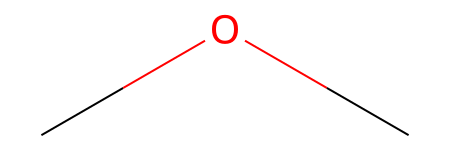

In [10]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [11]:
df = pd.DataFrame(compiled_res)

In [16]:
grouped = df.groupby(['temp']).agg(['mean', 'std'])

In [17]:
grouped

noise_level           frac_valid           frac_unique            \
            mean       std       mean       std        mean       std   
temp                                                                    
0.00    2.916667  3.891229   0.994565  0.013312    0.021922  0.007228   
0.10    2.916667  3.891229   0.992754  0.011226    0.043961  0.023540   
0.20    2.916667  3.891229   0.974638  0.044375    0.108157  0.039578   
0.50    2.916667  3.891229   0.971014  0.021374    0.359797  0.028427   
0.75    2.916667  3.891229   0.918478  0.043884    0.555132  0.028139   
1.00    2.916667  3.891229   0.664855  0.014447    0.755052  0.069493   
1.25    2.916667  3.891229   0.313406  0.039740    0.892921  0.063353   
1.50    2.916667  3.891229   0.106884  0.030292    1.000000  0.000000   
2.00    2.916667  3.891229   0.125000  0.035555    1.000000  0.000000   

     frac_smiles_in_train      frac_smiles_in_pubchem            ...  \
                     mean  std                   mean       std  ...   
temp                                                             ...   
0.00                  0.0  0.0               1.000000  0.000000  ...   
0.10                  0.0  0.0               1.000000  0.000000  ...   
0.20                  0.0  0.0               1.000000  0.000000  ...   
0.50                  0.0  0.0               1.000000  0.000000  ...   
0.75                  0.0  0.0               1.000000  0.000000  ...   
1.00                  0.0  0.0               1.000000  0.000000  ...   
1.25                  0.0  0.0               1.000000  0.000000  ...   
1.50                  0.0  0.0               1.000000  0.000000  ...   
2.00                  0.0  0.0               0.972222  0.068041  ...   

     z_pi_pi_star_r2           z_pi_pi_star_max_error             \
                mean       std                   mean        std   
temp                                                               
0.00       -0.019570  0.022283              52.931186   3.119836   
0.10       -0.036519  0.033815              53.688701   3.518165   
0.20       -0.055093  0.067049              53.189046   3.514610   
0.50       -0.191551  0.085945              61.518354   6.847675   
0.75       -0.215839  0.134125              65.668732  11.091720   
1.00       -0.323246  0.146523              68.099655  10.578059   
1.25       -0.769153  0.490967              57.030038   6.403712   
1.50       -5.225031  6.018130              51.939797   5.624758   
2.00       -6.770715  4.261112              58.914742  13.357223   

     z_pi_pi_star_mean_absolute_error            \
                                 mean       std   
temp                                              
0.00                        13.557117  1.163936   
0.10                        13.739110  1.010177   
0.20                        13.976706  1.061089   
0.50                        14.768541  1.314791   
0.75                        14.490057  1.457382   
1.00                        15.718704  1.849756   
1.25                        16.911339  2.851603   
1.50                        25.822429  4.149902   
2.00                        33.213467  4.588438   

     z_pi_pi_star_mean_squared_error             z_pi_pi_star_rmse            
                                mean         std              mean       std  
temp                                                                          
0.00                      334.447879   38.755118         18.263791  1.028677  
0.10                      343.542746   31.086674         18.520052  0.812710  
0.20                      353.301438   39.277320         18.773353  1.017449  
0.50                      394.712500   58.383441         19.823404  1.447134  
0.75                      396.510347   77.552217         19.835809  1.913435  
1.00                      474.437672   87.293813         21.710761  1.922665  
1.25                      498.944802  117.091472         22.186441  2.836895  
1.50                      933.744601  193.9

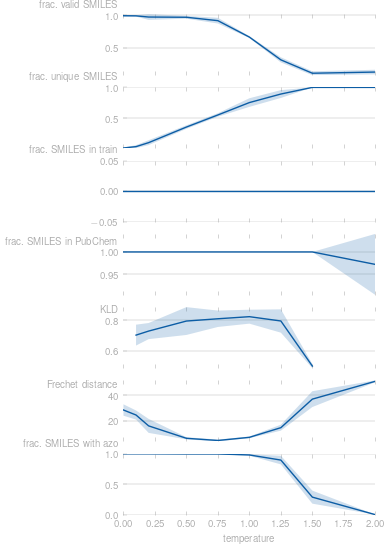

In [18]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(7,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, 2*ONE_COL_WIDTH_INCH))
    ax[0].plot(grouped.index, grouped['frac_valid']['mean'], label='frac_valid')
    ax[0].fill_between(grouped.index, grouped['frac_valid']['mean'] - grouped['frac_valid']['std'], grouped['frac_valid']['mean'] + grouped['frac_valid']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. valid SMILES', ax=ax[0])

    ax[1].plot(grouped.index, grouped['frac_unique']['mean'], label='frac_unique')
    ax[1].fill_between(grouped.index, grouped['frac_unique']['mean'] - grouped['frac_unique']['std'], grouped['frac_unique']['mean'] + grouped['frac_unique']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. unique SMILES', ax=ax[1])

    ax[2].plot(grouped.index, grouped['frac_smiles_in_train']['mean'], label='frac_smiles_in_train')
    ax[2].fill_between(grouped.index, grouped['frac_smiles_in_train']['mean'] - grouped['frac_smiles_in_train']['std'], grouped['frac_smiles_in_train']['mean'] + grouped['frac_smiles_in_train']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES in train', ax=ax[2])

    ax[3].plot(grouped.index, grouped['frac_smiles_in_pubchem']['mean'], label='frac_smiles_in_pubchem')
    ax[3].fill_between(grouped.index, grouped['frac_smiles_in_pubchem']['mean'] - grouped['frac_smiles_in_pubchem']['std'], grouped['frac_smiles_in_pubchem']['mean'] + grouped['frac_smiles_in_pubchem']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES in PubChem', ax=ax[3])

    ax[4].plot(grouped.index, grouped['kld']['mean'], label='kld')
    ax[4].fill_between(grouped.index, grouped['kld']['mean'] - grouped['kld']['std'], grouped['kld']['mean'] + grouped['kld']['std'], alpha=0.2)

    matplotx.ylabel_top('KLD', ax=ax[4])

    ax[5].plot(grouped.index, grouped['frechet_d']['mean'], label='frechet_d')
    ax[5].fill_between(grouped.index, grouped['frechet_d']['mean'] - grouped['frechet_d']['std'], grouped['frechet_d']['mean'] + grouped['frechet_d']['std'], alpha=0.2)

    matplotx.ylabel_top('Frechet distance', ax=ax[5])

    ax[6].plot(grouped.index, grouped['frac_contains_azo']['mean'], label='frechet_score')
    ax[6].fill_between(grouped.index, grouped['frac_contains_azo']['mean'] - grouped['frac_contains_azo']['std'], grouped['frac_contains_azo']['mean'] + grouped['frac_contains_azo']['std'], alpha=0.2)

    matplotx.ylabel_top('frac. SMILES with azo', ax=ax[6])

    ax[-1].set_xlabel('temperature', labelpad=4)

    fig.savefig('photoswitch_random_smiles_metrics.pdf', bbox_inches='tight')

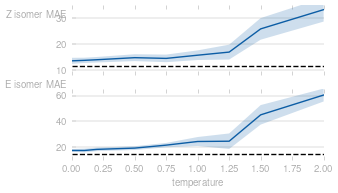

In [19]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(2,1, sharex='all', figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

    ax[0].plot(grouped.index, grouped['z_pi_pi_star_mean_absolute_error']['mean'], label='e_pi_pi_star_metrics')
    ax[0].fill_between(grouped.index, grouped['z_pi_pi_star_mean_absolute_error']['mean'] - grouped['z_pi_pi_star_mean_absolute_error']['std'], grouped['z_pi_pi_star_mean_absolute_error']['mean'] + grouped['z_pi_pi_star_mean_absolute_error']['std'], alpha=0.2)

    matplotx.ylabel_top('Z isomer MAE', ax=ax[0])

    ax[0].hlines(11.616605626696359, 0, 2, color='k', linestyle='--')

    ax[0].set_ylim(8,35)

    ax[1].plot(grouped.index, grouped['e_pi_pi_star_mean_absolute_error']['mean'], label='e_pi_pi_star_metrics')
    ax[1].fill_between(grouped.index, grouped['e_pi_pi_star_mean_absolute_error']['mean'] - grouped['e_pi_pi_star_mean_absolute_error']['std'], grouped['e_pi_pi_star_mean_absolute_error']['mean'] + grouped['e_pi_pi_star_mean_absolute_error']['std'], alpha=0.2)

    matplotx.ylabel_top('E isomer MAE', ax=ax[1])

    ax[1].hlines(14.38998132190228, 0, 2, color='k', linestyle='--')

    ax[-1].set_xlabel('temperature', labelpad=4)
    ax[1].set_ylim(10,65)
fig.savefig('random_photoswitch_constrain_matches.pdf', bbox_inches='tight')

## Visualize

In [20]:
import tmap as tm
import numpy as np

from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem

from tqdm import tqdm

In [21]:
import os
import shutil

In [28]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data['SMILES'].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
    clear_color="#FFFFFF",
    coords=False,
    view="free",
    impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader='sphere',
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [29]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 403/403 [00:03<00:00, 111.98it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 403/403 [00:03<00:00, 110.91it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 404/404 [00:03<00:00, 109.57it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 421/421 [00:03<00:00, 115.30it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 469/469 [00:03<00:00, 119.04it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 510/510 [00:04<00:00, 120.75it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 489/489 [00:04<00:00, 116.34it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 451/451 [00:03<00:00, 123.56it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 472/472 [00:03<00:00, 129.69it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [55]:
make_figure(1.5)

100%|██████████| 440/440 [00:04<00:00, 93.61it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html